# How Good is the Reconstruction?

In [1]:
using EDM4hep
using EDM4hep.RootIO
using Plots, FHist

## Missing functionality for the analysis
- Taken the HelixClass form MarlinUtils
- Histogram fitting. Using the package [LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl)

In [2]:
# Missing functionality  (taken from MarlinUtil)
const FCT=2.99792458e-4
struct HelixClass
    pos::Vector3d           # position of the reference point : pos[3]; <br>
    momentum::Vector3d      # momentum vector at the reference point : mom[3];<br>
    charge::Float32         # particle charge : q;<br>
    B::Float64              # magnetic field (in Tesla) : B<br>
    # calculated
    pxy::Float64
    radius::Float64
    omega::Float64
    ϕ₀::Float64

    function HelixClass(pos, mom, q, B)
        pxy = sqrt(mom.x^2 + mom.y^2)
        radius = pxy /(FCT*B)
        omega = q/radius
        ϕMomRefPoint = atan(mom.y, mom.x)
        xCentre = pos.x + radius * cos(ϕMomRefPoint-π/2*q)
        yCentre = pos.y + radius * sin(ϕMomRefPoint-π/2*q)
        ϕRefPoint = atan(pos.y - yCentre, pos.x - xCentre)
        ϕAtPCA = atan(-yCentre, -xCentre)
        ϕ₀ = -π/2 * q + ϕAtPCA
        while ϕ₀ < 0; ϕ₀ += 2π; end
        while ϕ₀ >= 2π; ϕ₀ -= 2π; end
        new(pos, mom, q, B, pxy, radius, omega, ϕ₀)
    end
end


# Fit and Plot histograms
using LsqFit
gaus(x,p) = p[1] * exp.(-0.5*((x.-p[2])/p[3]).^2)
function fit_and_plot(h, model; title="", xlabel="")
    fit = curve_fit(model, collect(bincenters(h)), bincounts(h), [1500.,0.,1.])
    nDf = (nbins(h) - 3)
    chi2 = sum(fit.resid .^ 2) / nDf
    println("""
            ****************************************
            Minimizer is LsqFit
            Chi2                      = $chi2
            NDf                       = $nDf
            Constant                  = $(fit.param[1])    
            Mean                      = $(fit.param[2])    
            Sigma                     = $(fit.param[3])
            ****************************************
            """)
    plot(h, title=title, xlabel=xlabel)
    plot!(bincenters(h), model(bincenters(h), fit.param))        
end


fit_and_plot (generic function with 1 method)

In [3]:
file = "/Users/mato/Downloads/E250-SetA.P4f_sw_sl.Gwhizard-2_8_5.eL.pR.I500106.0.1000.REC_edm4hep.root"
reader = RootIO.Reader(file)
events = RootIO.get(reader, "events");

In [4]:
h_omega = Hist1D(bins=range(-10,10,51))
h_phi = Hist1D(bins=range(-10,10,51))
h_momentum = Hist1D(bins=range(0,125,126))
h_omega_2d = Hist2D(bins=(range(0,125,11),range(-10,10,51)));

In [5]:
empty!(h_omega)
empty!(h_phi)
empty!(h_momentum)
empty!(h_omega_2d)

for evt in events
    mctruthrecolinks = RootIO.get(reader, evt, "SiTracksMCTruthLink")
    RootIO.get(reader, evt, "MCParticles")            #---no implicit reading for the moment
    RootIO.get(reader, evt, "SiTracks_Refitted")      #---no implicit reading for the moment
    for link in mctruthrecolinks
        weight = link.weight
        mcp = link.sim
        reco = link.rec
        # FIXME: ah lol does this direction in the relation kill electrons with high brems loss as the fraction of their initial energy going to the track is lower?
        weight < 0.9 && continue
        # only care about electrons
        (abs(mcp.PDG) != 11 || mcp.generatorStatus != 1) && continue
        # require at least some energy
        # FIXME: probably should cut on pT instead
        mcp.energy < 1 && continue

        reco_track = reco.trackStates[1]
        cov = reco_track.covMatrix
        mc_track = HelixClass(mcp.vertex, mcp.momentum, mcp.charge, 2.)
        pull_omega = (reco_track.omega - mc_track.omega) / sqrt(cov[6])
        pull_phi = (reco_track.phi - mc_track.ϕ₀) / sqrt(cov[3])
        
        push!(h_omega, pull_omega)
        push!(h_phi, pull_phi)
        push!(h_momentum, mcp.energy)
        push!(h_omega_2d, mcp.energy, pull_omega)

    end
end


****************************************
Minimizer is LsqFit
Chi2                      = 28.859126407070935
NDf                       = 47
Constant                  = 39.88947224239148    
Mean                      = 0.007977036962486514    
Sigma                     = 2.3575883644579174
****************************************



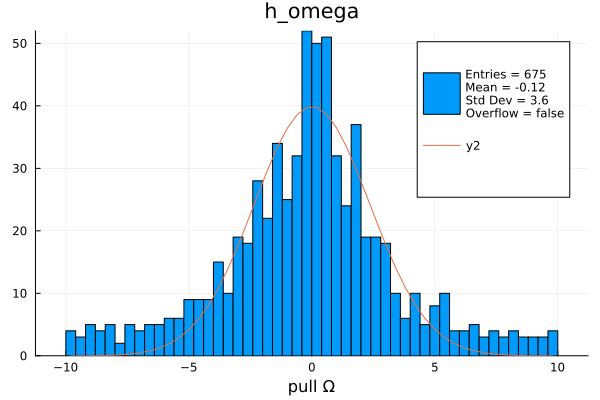

In [6]:
fit_and_plot(h_omega, gaus; title="h_omega", xlabel="pull Ω")

****************************************
Minimizer is LsqFit
Chi2                      = 9.030523198723774
NDf                       = 47
Constant                  = 54.099109826994216    
Mean                      = -0.021213100095317208    
Sigma                     = 1.4067422620691046
****************************************



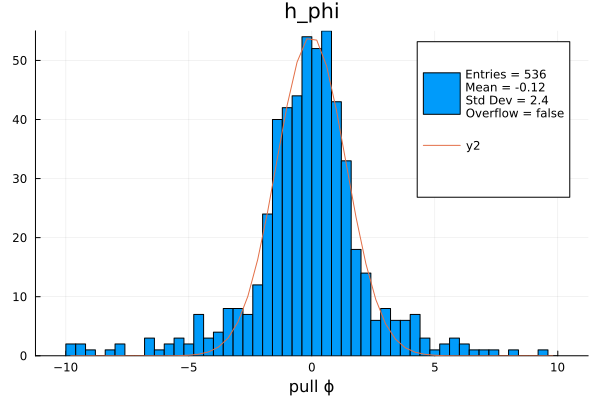

In [7]:
fit_and_plot(h_phi, gaus; title="h_phi", xlabel="pull ϕ")

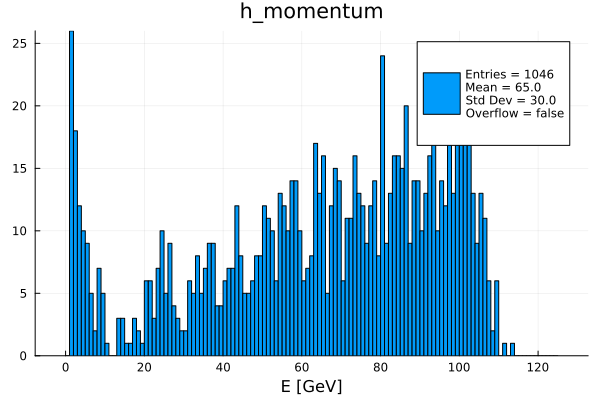

In [8]:
plot(h_momentum, title="h_momentum", xlabel="E [GeV]")

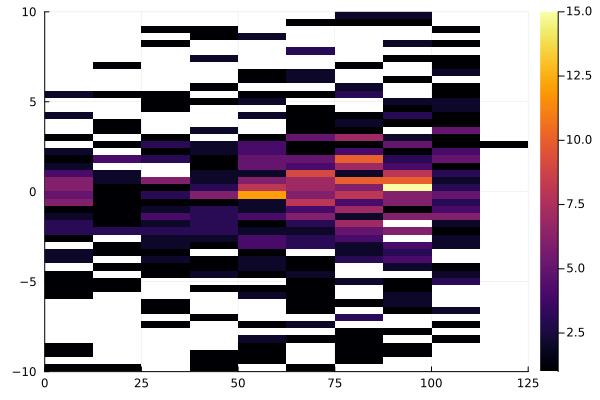

In [9]:
plot(h_omega_2d)